In [54]:
import os

from scipy.stats import poisson
from statsmodels.genmod.generalized_linear_model import GLMResultsWrapper
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [20]:
plt.rcParams["figure.figsize"] = 12/2.54, 8/2.54

## Distribution of shots and goals

First, let us use WyScout data to plot the distribution of shots and goals in a Bundesliga season. Let us first load the data.

In [2]:
data_dir: str = "../../data/wyscout/events"

In [3]:
data: pd.DataFrame = pd.read_json(os.path.join(data_dir, "events_Germany.json"))
data.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],15231,"[{'y': 50, 'x': 50}, {'y': 48, 'x': 50}]",2516739,Pass,2446,1H,2.409746,85,179896442
1,8,Simple pass,[{'id': 1801}],14786,"[{'y': 48, 'x': 50}, {'y': 22, 'x': 22}]",2516739,Pass,2446,1H,2.506082,85,179896443
2,8,Simple pass,[{'id': 1801}],14803,"[{'y': 22, 'x': 22}, {'y': 46, 'x': 6}]",2516739,Pass,2446,1H,6.946706,85,179896444
3,8,Simple pass,[{'id': 1801}],14768,"[{'y': 46, 'x': 6}, {'y': 10, 'x': 20}]",2516739,Pass,2446,1H,10.786491,85,179896445
4,8,Simple pass,[{'id': 1801}],14803,"[{'y': 10, 'x': 20}, {'y': 4, 'x': 27}]",2516739,Pass,2446,1H,12.684514,85,179896446


In [4]:
data.shape

(519407, 12)

Next, let us add an indicator column that specifies if the event (i.e. row) refers to a shot on goal.

In [ ]:
shot_event_names: list = ["Shot", "Free kick shot", "Penalty"]

In [6]:
shots = data[data["subEventName"].isin(shot_event_names)]
shots.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
104,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1206}, {'id'...",209091,"[{'y': 66, 'x': 83}, {'y': 0, 'x': 0}]",2516739,Shot,2444,1H,247.703507,100,179896573
178,10,Shot,"[{'id': 101}, {'id': 403}, {'id': 201}, {'id':...",134383,"[{'y': 59, 'x': 95}, {'y': 0, 'x': 0}]",2516739,Shot,2444,1H,529.393731,100,179896639
216,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1201}, {'id'...",105619,"[{'y': 66, 'x': 91}, {'y': 100, 'x': 100}]",2516739,Shot,2446,1H,668.234340,100,179896684
220,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1212}, {'id'...",14786,"[{'y': 49, 'x': 88}, {'y': 100, 'x': 100}]",2516739,Shot,2446,1H,672.925920,100,179896693
313,10,Shot,"[{'id': 402}, {'id': 1216}, {'id': 1802}]",20475,"[{'y': 42, 'x': 74}, {'y': 0, 'x': 0}]",2516739,Shot,2444,1H,949.131592,100,179896798


We need another column that specifies if a shot resulted in a goal. This information is present in the `tags` column. If there was a goal scored from a shot, it contains a dictionary with a value `101` for the `id` key. Let us create this column.

In [7]:
def is_shot_id_present(tags: list) -> int:
    tag: dict
    for tag in tags:
        if tag["id"] == 101:
            return 1
    return 0

In [8]:
shots.loc[:, "goal"] = shots.apply(lambda x: is_shot_id_present(x["tags"]), axis=1)
shots.head()

/var/folders/_f/_mxr3yps0dn2fp263fqj4yy00000gn/T/ipykernel_29625/4021192228.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots.loc[:, "goal"] = shots.apply(lambda x: is_shot_id_present(x["tags"]), axis=1)


,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,goal
104,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1206}, {'id'...",209091,"[{'y': 66, 'x': 83}, {'y': 0, 'x': 0}]",2516739,Shot,2444,1H,247.703507,100,179896573,0
178,10,Shot,"[{'id': 101}, {'id': 403}, {'id': 201}, {'id':...",134383,"[{'y': 59, 'x': 95}, {'y': 0, 'x': 0}]",2516739,Shot,2444,1H,529.393731,100,179896639,1
216,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1201}, {'id'...",105619,"[{'y': 66, 'x': 91}, {'y': 100, 'x': 100}]",2516739,Shot,2446,1H,668.234340,100,179896684,0
220,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1212}, {'id'...",14786,"[{'y': 49, 'x': 88}, {'y': 100, 'x': 100}]",2516739,Shot,2446,1H,672.925920,100,179896693,0
313,10,Shot,"[{'id': 402}, {'id': 1216}, {'id': 1802}]",20475,"[{'y': 42, 'x': 74}, {'y': 0, 'x': 0}]",2516739,Shot,2444,1H,949.131592,100,179896798,0


As we want to visualise the distribution of shots and goals over an entire season, let us aggregate them by match.

In [9]:
shots_per_match: list = []
goals_per_match: list = []
match_id: str
match_data: pd.DataFrame
for match_id, match_data in shots.groupby("matchId"):
    shots_per_match.append(len(match_data))
    goals_per_match.append(sum(match_data["goal"]))

First, let us create a histogram of the goals.

In [15]:
mean_goals: float = np.mean(goals_per_match)
goals_dist: np.ndarray
goals_bins: np.ndarray
goals_dist, goals_bins = np.histogram(goals_per_match, bins=np.arange(-0.5, 10.5))
goals_dist = goals_dist / shots["matchId"].nunique()

Based on the mean goals, let us create a Poisson distribution.

In [19]:
possible_goals: np.ndarray = np.arange(0, 10).astype(int)
x: int
possible_goals_factorial: np.ndarray = np.array([np.math.factorial(x) for x in possible_goals])
poisson_possible_goals: np.ndarray = np.power(mean_goals, possible_goals) * np.exp(-mean_goals) / possible_goals_factorial

Finally, let us plot the distribution of goals in the Bundesliga season.

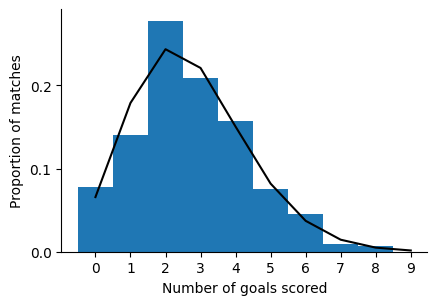

In [21]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.hist(possible_goals - 0.5, 9, weights=goals_dist)
plt.plot(possible_goals, poisson_possible_goals, color="black")
ax.set_yticks(np.arange(0, 0.3, 0.1))
ax.spines["left"].set_visible(True)
ax.spines["bottom"].set_position("zero")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xticks(np.arange(0, 10, 1))
ax.set_ylabel("Proportion of matches")
ax.set_xlabel("Number of goals scored")
plt.show()


#Exercise:
#1, Make a histogram of shots per game
#2, Find the mean and standard deviation for shots per game
#3, Show that shots per game is roughly normally distributed.

Some observations from the plot above are:
- The Poisson distribution under-represents games with 2 goals (2-0, 0-2, or 1-1) while it over-represents single goal games.

Let us now recreate the charts for shots per game. As there are way more shots per game than the number of goals, the Binomial distribution, which is the basis, converges to Normal distribution under the Law of Large Numbers. So, just like we plotted the Poisson distribution (as a Black line) with the mean number of goals per game as the parameters, we will need the mean number of shots per game and the standard deviation as parameters to plot the Normal distribution.

In [27]:
mean_shots: float = np.mean(shots_per_match)
std_shots: float = np.std(shots_per_match)
shots_dist: np.ndarray
shots_bins: np.ndarray
shots_dist, shots_bins = np.histogram(shots_per_match, bins=np.arange(-0.5, 50.5))
shots_dist = shots_dist / shots["matchId"].nunique()

In [28]:
possible_shots: np.ndarray = np.arange(0, 50).astype(int)
x: int
normal_possible_shots: np.ndarray = np.array([scipy.stats.norm(mean_shots, std_shots).pdf(x) for x in possible_shots])

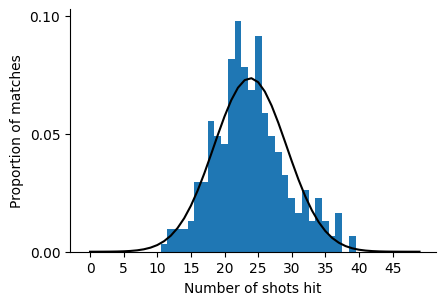

In [35]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.hist(possible_shots - 0.5, 49, weights=shots_dist)
plt.plot(possible_shots, normal_possible_shots, color="black")
ax.set_yticks(np.arange(0, 0.15, 0.05))
ax.spines["left"].set_visible(True)
ax.spines["bottom"].set_position("zero")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xticks(np.arange(0, 50, 5))
ax.set_ylabel("Proportion of matches")
ax.set_xlabel("Number of shots hit")
plt.show()


Some observations from the chart above:
- There seem to be at least 10 shots per game and at most 39.
- As the mean of the distribution suggests, there are 20-25 shots taken per game.

## Simulate a season

Let us now see how to simulate matches over an entire season based on the league table for the previous season. We begin by download the table for the 2019-20 season of the English Premier League.

In [37]:
epl: pd.DataFrame = pd.read_csv("https://www.football-data.co.uk/mmz4281/1920/E0.csv")
epl.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,09/08/2019,20:00,Liverpool,Norwich,4,1,H,4,0,...,3.43,-2.25,1.91,1.99,1.94,1.98,1.99,2.07,1.90,1.99
1,E0,10/08/2019,12:30,West Ham,Man City,0,5,A,0,1,...,2.91,1.75,1.95,1.95,1.96,1.97,2.07,1.98,1.97,1.92
2,E0,10/08/2019,15:00,Bournemouth,Sheffield United,1,1,D,0,0,...,1.92,-0.50,1.95,1.95,1.98,1.95,2.00,1.96,1.96,1.92
3,E0,10/08/2019,15:00,Burnley,Southampton,3,0,H,0,0,...,1.71,0.00,1.87,2.03,1.89,2.03,1.90,2.07,1.86,2.02
4,E0,10/08/2019,15:00,Crystal Palace,Everton,0,0,D,0,0,...,1.71,0.25,1.82,2.08,1.97,1.96,2.03,2.08,1.96,1.93


Let us select the required columns and name them according to our preferences.

In [38]:
epl = epl.loc[:, ["HomeTeam", "AwayTeam", "FTHG", "FTAG"]].rename(columns={"FTHG": "HomeGoals", "FTAG": "AwayGoals"})
epl.head()

,HomeTeam,AwayTeam,HomeGoals,AwayGoals
0,Liverpool,Norwich,4,1
1,West Ham,Man City,0,5
2,Bournemouth,Sheffield United,1,1
3,Burnley,Southampton,3,0
4,Crystal Palace,Everton,0,0


Next, we want to fit a Poisson model that estimates the numbers of goals that will be scored by a team given the fixed effects like the base rate of the team itself, the opponent, and whether the game is at home or away. This is also called the *Dickson-Coles Model*. To fit this model, let us first construct the data.

In [39]:
goal_model_data: pd.DataFrame = pd.concat([
    (epl[["HomeTeam", "AwayTeam", "HomeGoals"]].assign(home=1)
     .rename(columns={"HomeTeam": "team", "AwayTeam": "opponent", "HomeGoals": "goals"})),
    (epl[["AwayTeam", "HomeTeam", "AwayGoals"]].assign(home=0)
     .rename(columns={"AwayTeam": "team", "HomeTeam": "opponent", "AwayGoals": "goals"}))
])
goal_model_data.head()

,team,opponent,goals,home
0,Liverpool,Norwich,4,1
1,West Ham,Man City,0,1
2,Bournemouth,Sheffield United,1,1
3,Burnley,Southampton,3,1
4,Crystal Palace,Everton,0,1


Now we fit the model using the `statsmodels` package.

In [45]:
poisson_model: GLMResultsWrapper = smf.glm(formula="goals ~ home + team + opponent",
                                           data=goal_model_data,
                                           family=sm.families.Poisson()).fit()
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                  760
Model:                            GLM   Df Residuals:                      720
Model Family:                 Poisson   Df Model:                           39
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1057.7
Date:                Thu, 09 Mar 2023   Deviance:                       765.20
Time:                        08:59:11   Pearson chi2:                     655.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2118
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.1957      0.202      0.967      0.334      -0.201       0.593
team[T.Aston Villa]             -0.2932      0.206     -1.424      0.154      -0.697       0.110
team[T.Bournemouth]             -0.3200      0.207     -1.544      0.123      -0.726       0.086
team[T.Brighton]                -0.3566      0.209     -1.708      0.088      -0.766       0.053
team[T.Burnley]                 -0.2628      0.203     -1.294      0.196      -0.661       0.135
team[T.Chelsea]                  0.2157      0.180      1.197      0.231      -0.137       0.569
team[T.Crystal Palace]          -0.5906      0.224     -2.636      0.008      -1.030      -0.151
team[T.Everton]                 -0.2336      0.202     -1.158      0.247      -0.629       0.162
team[T.Leicester]                0.1727      0.181      0.952      0.341      -0.183       0.528
team[T.Liverpool]                0.4031      0.172      2.339      0.019       0.065       0.741
team[T.Man City]                 0.5881      0.167      3.530      0.000       0.262       0.915
team[T.Man United]               0.1525      0.182      0.838      0.402      -0.204       0.509
team[T.Newcastle]               -0.3786      0.210     -1.799      0.072      -0.791       0.034
team[T.Norwich]                 -0.7416      0.238     -3.121      0.002      -1.207      -0.276
team[T.Sheffield United]        -0.3716      0.209     -1.780      0.075      -0.781       0.038
team[T.Southampton]             -0.0815      0.194     -0.420      0.674      -0.461       0.298
team[T.Tottenham]                0.0847      0.185      0.457      0.647      -0.279       0.448
team[T.Watford]                 -0.4266      0.214     -1.995      0.046      -0.846      -0.007
team[T.West Ham]                -0.1195      0.196     -0.610      0.542      -0.504       0.264
team[T.Wolves]                  -0.1019      0.194     -0.526      0.599      -0.482       0.278
opponent[T.Aston Villa]          0.3191      0.189      1.685      0.092      -0.052       0.690
opponent[T.Bournemouth]          0.2876      0.191      1.509      0.131      -0.086       0.661
opponent[T.Brighton]             0.1008      0.199      0.507      0.612      -0.289       0.490
opponent[T.Burnley]              0.0277      0.202      0.137      0.891      -0.369       0.424
opponent[T.Chelsea]              0.1316      0.199      0.663      0.508      -0.258       0.521
opponent[T.Crystal Palace]       0.0156      0.202      0.077      0.938      -0.381       0.412
opponent[T.Everton]              0.1423      0.197      0.722      0.470      -0.244       0.528
opponent[T.Leicester]           -0.1468      0.213     -0.689      0.491      -0.564       0.271
opponent[T.Liverpool]           -0.3459      0.226     -1.527      0.127    

In the result above, the *intercept* refers to the first team in our data i.e. Arsenal. Some observations from the model summary are:
- As the y-variable is the number of goals scored, coefficients of the home team (starting with `team`) represents how many more or fewer goals they score as compared to Arsenal per game. We see that only a handful of teams like Manchester City, Liverpool do better on this metric than Arsenal.
- The coefficients of the away team (starting with `opponent`) indicate how many goals more does a team concede per game as compared to Arsenal.
- We need to pay attention to the significance of these coefficients i.e. the $P > |z|$ column. A coefficient is said to be statistically significant if its p-value is less than `0.05`. When we consider the P-value, we see that only Manchester City and Liverpool score statistically significant more goals than Arsenal. Watford, Norwich, and Crystal Palace. We cannot make the same argument for any team conceding more goals than Arsenal.
- Regardless of the fixed effects, we can see that playing at home carries a significant advantage in terms of the number of goals scored.

Let us now consider the home team to be Manchester City and the away team to the Arsenal. We can use the model to predict the goals scored by each team in this case.

In [46]:
home_team: str = "Man City"
away_team: str = "Arsenal"

In [51]:
home_score_rate: pd.DataFrame = poisson_model.predict(
    pd.DataFrame(
        data={
            "team": home_team,
            "opponent": away_team,
            "home": 1
        },
        index=[1]
    )
)
away_score_rate: pd.DataFrame = poisson_model.predict(
    pd.DataFrame(
        data={
            "team": away_team,
            "opponent": home_team,
            "home": 0
        },
        index=[1]
    )
)
print(f"{home_team} against {away_team} expect to score: {round(home_score_rate.loc[1], 2)}")
print(f"{away_team} against {home_team} expect to score: {round(away_score_rate.loc[1], 2)}")

Man City against Arsenal expect to score: 2.75
Arsenal against Man City expect to score: 0.93


Given that we derived the results from a Poisson model, the predictions above can be considered as the mean of the distribution. We can then simulate multiple matches between these two teams by providing this mean to the Poisson distribution.

Let us write a function to do so. In this function, we will compute two lists, one each for the home and away team. The list represents the probability of the team scoring $i$ goals, where $i$ is the index (starting at 0), given the probability derived from our Poisson model. We then compute an outer matrix product of the two lists to yield the probabilities of various scorelines like 0-0, 1-0, etc.

In [63]:
def simulate_matches(
        goal_model: GLMResultsWrapper,
        home_side: str,
        away_side: str,
        max_goals: int = 10
):
    mean_home_goals: float = goal_model.predict(
        pd.DataFrame(
            data={
                "team": home_side,
                "opponent": away_side,
                "home": 1
            },
            index=[1]
        )
    ).loc[1]
    mean_away_goals: float = goal_model.predict(
        pd.DataFrame(
            data={
                "team": away_side,
                "opponent": home_side,
                "home": 0
            },
            index=[1]
        )
    ).loc[1]

    i: int
    team_mean: tuple
    # Given the mean scoring rate of a team, compute the probability that a team will
    # score `i` goals.
    simulated_goals: list = [[poisson.pmf(i, team_mean)
                              for i in range(0, (max_goals + 1))]
                              for team_mean in [mean_home_goals, mean_away_goals]]

    return np.outer(np.array(simulated_goals[0]), np.array(simulated_goals[1]))

In [64]:
required_max_goals: int = 5
score_matrix: np.ndarray = simulate_matches(poisson_model, home_team, away_team, max_goals=required_max_goals)
score_matrix

array([[0.02513598, 0.02336056, 0.01085528, 0.00336285, 0.00078133,
        0.00014523],
       [0.06922668, 0.06433704, 0.02989638, 0.00926158, 0.00215185,
        0.00039997],
       [0.09532816, 0.08859491, 0.04116862, 0.0127536 , 0.0029632 ,
        0.00055078],
       [0.08751403, 0.08133271, 0.037794  , 0.01170817, 0.0027203 ,
        0.00050563],
       [0.06025532, 0.05599935, 0.02602199, 0.00806133, 0.00187299,
        0.00034814],
       [0.03318969, 0.03084542, 0.01433337, 0.00444032, 0.00103167,
        0.00019176]])

In the table above, the rows represent the number of goals scored by Manchester City and the column represent goals by Arsenal. We see that the 2-0 scoreline has the highest probability.

Instead of focusing further on the numbers, let us create a heatmap of these probabilities to make it easier to read the results.

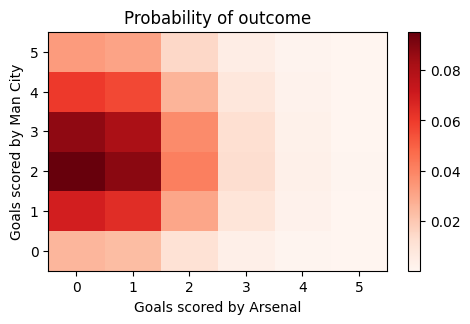

In [70]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

pos=ax.imshow(score_matrix,
              aspect="auto",
              cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title("Probability of outcome")
plt.xlim((-0.5, 5.5))
plt.ylim((-0.5, 5.5))
plt.tight_layout()
ax.set_xlabel(f"Goals scored by {away_team}")
ax.set_ylabel(f"Goals scored by {home_team}")
plt.show()

We can see that our model mostly predicts a win for Manchester city with them scoring 2-3 goals and Arsenal scoring 1-2 goals.